# FACE DETECTION WITHOUT PRE-TRAINED ALGORITHM

### Create the dataset

The dataset is composed:
- 4984 face images
- 2000 landscape images
- 2500 object images
- 583 body part imges

In [1]:
# -------------------------------
# Import libraries
# -------------------------------
 
 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib
import cv2
import random
import selectivesearch
import warnings
warnings.filterwarnings("ignore")

from sklearn.svm import SVC
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc
from skimage.util import view_as_windows
from sklearn.utils import shuffle
from skimage.color import rgb2gray
from scipy.ndimage import sobel
from skimage.feature import hog


# -------------------------------
# Load the Dataset
# -------------------------------


# Importing the datasets
df_faces= pd.read_csv("data/images_dataset.csv")


df_other= pd.read_csv("data/other_dataset.csv")
df_landscape= pd.read_csv("data/landscape_dataset.csv")
df_bodyno= pd.read_csv('data/body_no_face_dataset.csv')

df_other= df_other[:2500]
df_landscape= df_landscape[:2000]

# Display dataset shape for both datasets
print(f"Faces Dataset shape: {df_faces.shape}")
print(f"Other Dataset shape: {df_other.shape}")
print(f"Landscape Dataset shape: {df_landscape.shape}")
print(f"Bodyno Dataset shape: {df_bodyno.shape}")

Faces Dataset shape: (4984, 4096)
Other Dataset shape: (2500, 4096)
Landscape Dataset shape: (2000, 4096)
Bodyno Dataset shape: (583, 4096)


Manually labeling face/no face

In [2]:
# Add Label Column to datasets 0 for no faces, 1 for faces. This will be our y for predictions
df_faces['IsFace']= 1 # Faces
df_bodyno['IsFace']= 0 # Body without faces
df_other['IsFace']= 0 # Objects
df_landscape['IsFace']= 0 # Landscape

Split the target

In [3]:
# -------------------------------
# Split the target
# -------------------------------


# Split X and y train and test
X= pd.concat([df_faces.drop(columns= 'IsFace'), df_other.drop(columns= 'IsFace'), df_landscape.drop(columns= 'IsFace'),
              df_bodyno.drop(columns= 'IsFace')], axis= 0)
y= pd.concat([df_faces['IsFace'], df_other['IsFace'], df_landscape['IsFace'], df_bodyno['IsFace']], axis= 0)

# Reset indexes
X= X.reset_index(drop= True)
y= y.reset_index(drop= True)

print(f'X_shape: {X.shape}')

X_shape: (10067, 4096)


### Preprocessing and feature extraction

In [4]:
# -------------------------------
# Data Preprocessing & Feature Engineering
# -------------------------------


def normalize_image(image):
    """
    Normalize the image by scaling pixel values to the range [0, 1].
    
    Parameters:
    - image (ndarray): Image to be normalized.
    
    Returns:
    - image_normalized (ndarray): Normalized image.
    """
    return image / 255.0

scaler= MinMaxScaler()

In [5]:
# -------------------------------
# Hog Features Extraction
# -------------------------------


''' HOG is a feature descriptor that counts occurrences of gradient orientation in localized portions of an image. 
It divides the image into small regions called cells, computes a histogram of gradient directions within each cell, 
and then normalizes local contrast in overlapping blocks.
'''


def compute_hog_features(image, cell_size=(8, 8), block_size=(2, 2), bins=9):

    """
    This function computes the HOG features of an image. HOG features are used in computer vision
    to capture the structure of objects by analyzing the gradient information of an image.
    
    Parameters:
    - image (ndarray): The input image, assumed to be grayscale (2D array).
    - cell_size (tuple): The size of each cell (default is 8x8 pixels).
    - block_size (tuple): The size of each block of cells (default is 2x2 cells).
    - bins (int): The number of bins for the histogram of gradients (default is 9).
    
    Returns:
    - normalized_features (ndarray): The HOG features after block normalization.
    """
    
    # Convert the image to grayscale (if it's a color image)
    # If the image is already in grayscale (2D), this step is skipped.
    image_gray = rgb2gray(image) if image.ndim == 3 else image

    # Compute horizontal and vertical gradients using Sobel filters
    grad_x = sobel(image_gray, axis=1)  # Sobel filter for horizontal gradients (Gx)
    grad_y = sobel(image_gray, axis=0)  # Sobel filter for vertical gradients (Gy)

    # Compute gradient magnitude (intensity of the gradient)
    magnitude = np.sqrt(grad_x**2 + grad_y**2)

    # Compute gradient orientation in degrees
    # arctan2 returns the angle of the gradient (in radians), we convert it to degrees
    orientation = np.arctan2(grad_y, grad_x) * (180 / np.pi)
    
    # Ensure orientation is between [0, 180) degrees
    orientation = (orientation + 180) % 180

    # Divide the image into non-overlapping cells
    # Each cell will have a size defined by the 'cell_size' parameter (default 8x8 pixels)
    cell_rows, cell_cols = image_gray.shape[0] // cell_size[0], image_gray.shape[1] // cell_size[1]
    hog_features = []

    # Loop through the image and compute histograms for each cell
    for i in range(cell_rows):
        for j in range(cell_cols):
            # Define the boundaries of the current cell
            row_start, row_end = i * cell_size[0], (i + 1) * cell_size[0]
            col_start, col_end = j * cell_size[1], (j + 1) * cell_size[1]
            
            # Get the magnitude and orientation of gradients for the current cell
            cell_magnitude = magnitude[row_start:row_end, col_start:col_end]
            cell_orientation = orientation[row_start:row_end, col_start:col_end]

            # Create a histogram for the gradients in the cell
            hist, _ = np.histogram(
                cell_orientation,
                bins=bins,  # Number of bins for the histogram
                range=(0, 180),  # Orientation range (0° to 180°)
                weights=cell_magnitude  # Weigh the bins by the gradient magnitude
            )
            hog_features.append(hist)  # Append the histogram to the feature list

    # Convert the list of histograms into a NumPy array
    hog_features = np.array(hog_features)

    # Normalize the histograms in blocks (group of adjacent cells)
    # Block normalization helps make the features invariant to changes in lighting and contrast
    block_rows, block_cols = cell_rows - block_size[0] + 1, cell_cols - block_size[1] + 1
    normalized_features = []

    for i in range(block_rows):
        for j in range(block_cols):
            # Extract the block (a block is a group of cells)
            block = hog_features[
                i:i + block_size[0],  # Block size in rows
                j:j + block_size[1],  # Block size in columns
            ].ravel()  # Flatten the block into a 1D array

            # Normalize the block by its L2-norm (Euclidean norm)
            # Adding a small constant (1e-6) to avoid division by zero
            norm = np.sqrt(np.sum(block**2) + 1e-6)
            normalized_features.append(block / norm)  # Append the normalized block to the feature list

    # Concatenate all normalized blocks to form the final feature vector
    return np.concatenate(normalized_features)

def process_image_row_normalized(row):
    """
    Normalize the image and compute its HOG features.

    Parameters:
    - row (pd.Series): A single row of the dataset, containing flattened image pixel values.

    Returns:
    - features (ndarray): The computed HOG features for the image.
    """
    # Reshape the row into a 64x64 image
    image = row.reshape(64, 64)
    
    # Normalize the image
    image_normalized = scaler.fit_transform(image)

    # Compute HOG features
    features = compute_hog_features(image_normalized)
    
    return features

In [6]:
# -------------------------------
# Gabor Filter
# -------------------------------


'''
A Gabor filter can be viewed as a sinusoidal plane of particular frequency and orientation, modulated by a Gaussian envelope.
'''


def compute_gabor_features(image, kernels):
    """
    Compute Gabor filter features for the given image using provided kernels.

    Parameters:
    - image (ndarray): Input grayscale image (2D).
    - kernels (list): List of Gabor filter kernels.

    Returns:
    - features (ndarray): Flattened Gabor features for the image.
    """
    # Convert to grayscale if necessary
    image_gray = rgb2gray(image) if image.ndim == 3 else image
    features = []

    for kernel in kernels:
        # Apply the Gabor filter to the image
        filtered = cv2.filter2D(image_gray, cv2.CV_64F, kernel)
        features.append(filtered.mean())  # Mean intensity of the filtered result
        features.append(filtered.std())   # Standard deviation

    return np.array(features)

def create_gabor_kernels():
    """
    Create Gabor filter kernels with varying orientations and frequencies.

    Returns:
    - kernels (list): List of Gabor filter kernels.
    """
    kernels = []
    orientations = 8  # Number of orientations
    for theta in np.linspace(0, np.pi, orientations):  # Angles from 0 to 180 degrees
        for sigma in (1, 3):  # Different standard deviations
            for lamda in (10, 20):  # Wavelengths
                for gamma in (0.5, 1):  # Aspect ratios
                    kernel = cv2.getGaborKernel((9, 9), sigma, theta, lamda, gamma, 0, ktype=cv2.CV_64F)
                    kernels.append(kernel)
    return kernels

# Prepare Gabor kernels
gabor_kernels = create_gabor_kernels()

def process_image_row_gabor(row):
    """
    Normalize the image and compute Gabor features.

    Parameters:
    - row (pd.Series): A single row of the dataset, containing flattened image pixel values.

    Returns:
    - features (ndarray): The computed Gabor features for the image.
    """
    # Reshape the row into a 64x64 image
    image = row.reshape(64, 64)
    
    # Normalize the image
    image_normalized = scaler.fit_transform(image)

    # Compute Gabor features
    features = compute_gabor_features(image_normalized, gabor_kernels)
    
    return features

In [7]:
# -------------------------------
# LoG Filter
# -------------------------------


def compute_log_features(image, sigma_values):
    """
    Compute Laplacian of Gaussian (LoG) filter features for the given image.

    Parameters:
    - image (ndarray): Input grayscale image (2D).
    - sigma_values (list): List of sigma values for the Gaussian blur.

    Returns:
    - features (ndarray): Flattened LoG features for the image.
    """
    # Convert to grayscale if necessary
    image_gray = rgb2gray(image) if image.ndim == 3 else image
    features = []

    for sigma in sigma_values:
        # Apply Gaussian blur with the given sigma
        blurred = cv2.GaussianBlur(image_gray, (0, 0), sigma)
        # Apply the Laplacian operator
        log_result = cv2.Laplacian(blurred, cv2.CV_64F)
        # Append the mean and standard deviation of the filtered result
        features.append(log_result.mean())
        features.append(log_result.std())

    return np.array(features)

def process_image_row_log(row):
    """
    Normalize the image and compute LoG features.

    Parameters:
    - row (pd.Series): A single row of the dataset, containing flattened image pixel values.

    Returns:
    - features (ndarray): The computed LoG features for the image.
    """
    # Reshape the row into a 64x64 image
    image = row.reshape(64, 64)
    
    # Normalize the image
    image_normalized = scaler.fit_transform(image)

    # Define sigma values for Gaussian blur
    sigma_values = [1, 2, 3]  # Adjust these values as needed

    # Compute LoG features
    features = compute_log_features(image_normalized, sigma_values)
    
    return features

In [ ]:
# -------------------------------
# Combine All Features
# -------------------------------

# Normalize Data
X= normalize_image(X)

# Create an X_array
X_array= np.array(X)

# Extract features from X array
X_hog = np.array([process_image_row_normalized(row.reshape(64, 64)) for row in X_array])
print(f"Final X_hog feature matrix shape (HOG): {X_hog.shape}")

X_gabor = np.array([process_image_row_gabor(row.reshape(64, 64)) for row in X_array])
print(f"Final X_gabor feature matrix shape (Gabor): {X_gabor.shape}")

X_log = np.array([process_image_row_log(row.reshape(64, 64)) for row in X_array])
print(f"Final X_log feature matrix shape (LoG): {X_log.shape}")


Final X_hog feature matrix shape (HOG): (10067, 196)
Final X_gabor feature matrix shape (Gabor): (10067, 128)
Final X_log feature matrix shape (LoG): (10067, 6)


In [ ]:
# -------------------------------
# Data Normalize and PCA
# -------------------------------


# PCA on hog and gabor first, that have too much features and can compromize log importance.


# PCA
pca_hog = PCA(n_components=0.95) 
hog_pca = pca_hog.fit_transform(X_hog)
pca_gabor = PCA(n_components=0.99)
gabor_pca= pca_gabor.fit_transform(X_gabor)
pca_log = PCA(n_components=0.99)
log_pca= pca_log.fit_transform(X_log)

print(f"X_hog PCA feature shape: {hog_pca.shape}")
print(f"X_gabor PCA  matrix shape: {gabor_pca.shape}")
print(f"X_log PCA  matrix shape: {log_pca.shape}")

# Combine features
X_combined = np.hstack((hog_pca, gabor_pca, log_pca)) 
print(f"Final feature matrix shape: {X_combined.shape}")

X_hog PCA feature shape: (10067, 99)
X_gabor PCA  matrix shape: (10067, 2)
X_log PCA  matrix shape: (10067, 2)
Final feature matrix shape: (10067, 103)


Train, vlaidation and test split

In [ ]:
# -------------------------------
# Train and Test Split
# -------------------------------


# Train+Validation and Test
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X_combined, y, test_size=0.2, random_state=42, stratify=y  # 20% test
)

# Train and Validation
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.25, random_state=42, stratify=y_train_val  # 25% train_val validation
)

# Print dimensions
print(f"Train set size: {X_train.shape[0]}")
print(f"Validation set size: {X_val.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")
print(f'Target on train: {y_train.value_counts()}')
print(f'Target on validation: {y_val.value_counts()}')
print(f'Target on test: {y_test.value_counts()}')

Train set size: 6039
Validation set size: 2014
Test set size: 2014
Target on train: IsFace
0    3049
1    2990
Name: count, dtype: int64
Target on validation: IsFace
0    1017
1     997
Name: count, dtype: int64
Target on test: IsFace
0    1017
1     997
Name: count, dtype: int64


### Select and create the model

In [ ]:
# -------------------------------
# Randomized Search
# -------------------------------


# Define the hyperparameters for SVM
param_grids = {
    'C': [0.01, 0.1, 1, 10, 100],               # Wider range of regularization
    'gamma': [10, 1, 0.1, 0.01, 0.001],         # Covers more values
    'kernel': ['rbf'],                          # Add polynomial kernel
}

best_models = {}
results = {}

print(f"Running RandomizedSearchCV for SVM...")

# Initialize the SVM model
model = SVC(probability=True, random_state=42)

# RandomizedSearchCV setup
randomized_search = RandomizedSearchCV(
    model,
    param_distributions=param_grids,
    n_iter=20,  # Number of parameter combinations to try
    scoring='accuracy',
    cv=3,       # Number of folds for cross-validation
    n_jobs=-1,  # Use all available processors
    verbose=10,
    random_state=42
)

# Fit and store the best model
randomized_search.fit(X_train, y_train)
best_models['SVM'] = randomized_search.best_estimator_
results['SVM'] = {
    'best_params': randomized_search.best_params_,
    'best_score': randomized_search.best_score_
}

print(f"Best parameters for SVM: {randomized_search.best_params_}")
print(f"Best cross-validation score for SVM: {randomized_search.best_score_}\n")

Running RandomizedSearchCV for SVM...
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best parameters for SVM: {'kernel': 'rbf', 'gamma': 0.1, 'C': 100}
Best cross-validation score for SVM: 0.906441463818513



In [ ]:
# Validation Set Predictions
y_val_pred = best_models['SVM'].predict(X_val)

# Validation set results
val_accuracy = accuracy_score(y_val, y_val_pred)
print(f"Validation Accuracy: {val_accuracy:.2f}")
print("Classification Report on Validation Set:")
print(classification_report(y_val, y_val_pred))

Validation Accuracy: 0.95
Classification Report on Validation Set:
              precision    recall  f1-score   support

           0       0.93      0.97      0.95      1017
           1       0.97      0.92      0.94       997

    accuracy                           0.95      2014
   macro avg       0.95      0.95      0.95      2014
weighted avg       0.95      0.95      0.95      2014



In [ ]:
# Test Set Predictions
y_test_pred = best_models['SVM'].predict(X_test)

# Test set results
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"Test Accuracy: {test_accuracy:.2f}")
print("Classification Report on Test Set:")
print(classification_report(y_test, y_test_pred))

Test Accuracy: 0.95
Classification Report on Test Set:
              precision    recall  f1-score   support

           0       0.93      0.97      0.95      1017
           1       0.97      0.92      0.94       997

    accuracy                           0.95      2014
   macro avg       0.95      0.95      0.95      2014
weighted avg       0.95      0.95      0.95      2014




Confusion Matrix:
[[986  31]
 [ 78 919]]


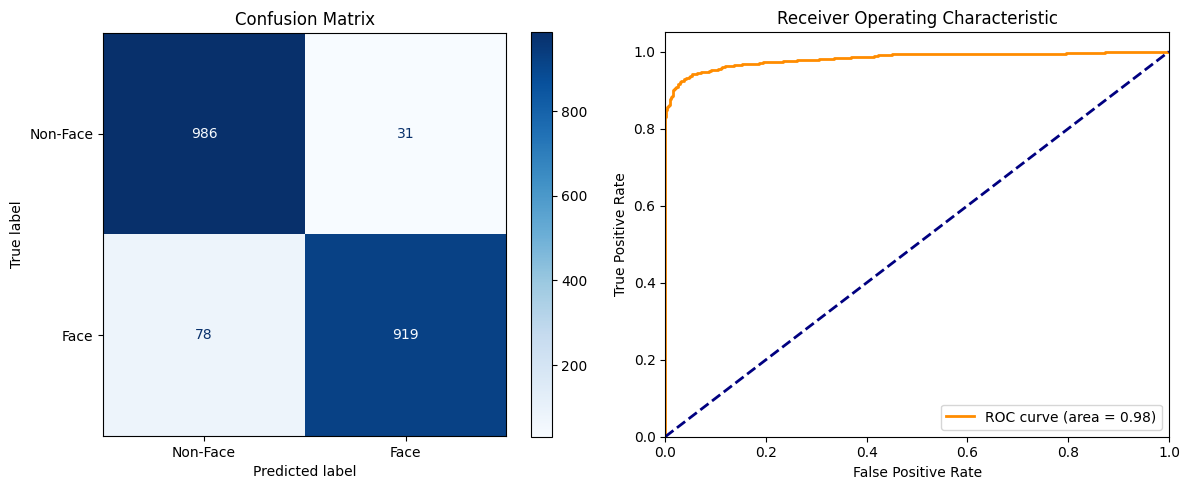

In [ ]:
# Confusion Matrix
print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_test_pred)
print(cm)

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, best_models['SVM'].predict_proba(X_test)[:, 1])
roc_auc = auc(fpr, tpr)

# Subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Confusion Matrix Plot
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Non-Face', 'Face'])
disp.plot(ax=axes[0], cmap='Blues', values_format='d')
axes[0].set_title("Confusion Matrix")

# ROC Curve Plot
axes[1].plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
axes[1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
axes[1].set_xlim([0.0, 1.0])
axes[1].set_ylim([0.0, 1.05])
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].set_title('Receiver Operating Characteristic')
axes[1].legend(loc='lower right')

# Plot Show
plt.tight_layout()
plt.show()

In [ ]:
# Predict probabilities for the test set
y_probs = best_models['SVM'].predict_proba(X_test)

# `y_probs` contains two columns:
# - The first column corresponds to the probability of the negative class (label 0)
# - The second column corresponds to the probability of the positive class (label 1)

# Get probabilities for the positive class (label 1)
positive_probs = y_probs[:, 1]

# Filter probabilities where the predicted label is 1
predicted_labels = model.predict(X_test)  # Get the predicted labels
predicted_positive_probs = positive_probs[predicted_labels == 1]

# Calculate the average, maximum, and minimum probability for predicted label 1
if len(predicted_positive_probs) > 0:
    average_predicted_positive = np.mean(predicted_positive_probs)
    median_predicted_positive= np.median(predicted_positive_probs)
    max_predicted_positive = np.max(predicted_positive_probs)
    min_predicted_positive = np.min(predicted_positive_probs)
    print(f"Average probability for predicted label 1: {average_predicted_positive:.2f}")
    print(f"Median probability for predicted label 1: {median_predicted_positive:.2f}")
    print(f"Maximum probability for predicted label 1: {max_predicted_positive:.2f}")
    print(f"Minimum probability for predicted label 1: {min_predicted_positive:.2f}")
else:
    print("No cases predicted as label 1.")

Average probability for predicted label 1: 0.97
Median probability for predicted label 1: 1.00
Maximum probability for predicted label 1: 1.00
Minimum probability for predicted label 1: 0.54


In [ ]:
# -------------------------------
# Model Export
# -------------------------------


# Save the model to a file
joblib.dump(best_models['SVM'], 'models/SVM_detection.pkl')
joblib.dump(pca_hog, "pca_hog.pkl")
joblib.dump(pca_gabor, "pca_gabor.pkl")
joblib.dump(pca_log, "pca_log.pkl")

['pca_log.pkl']

In [8]:
# -------------------------------
# Load Model
# -------------------------------


# Model
model = joblib.load('models/SVM_detection.pkl')
p_hog = joblib.load('models/pca_hog.pkl')
p_gabor = joblib.load('models/pca_gabor.pkl')
p_log = joblib.load('models/pca_log.pkl')

### New image analyze function

In [9]:
def non_maximum_suppression(boxes, scores, iou_threshold=0.5):

    """
    Performs Non-Maximum Suppression to avoid overlapping between bounding boxes.

    Parameters:
    - boxes (list of tuples): List of bounding boxes in the format (x, y, w, h).
    - scores (list of floats): List of probabilities associated with the bounding boxes.
    - iou_threshold (float): Intersection over Union threshold to suppress overlaps.

    Returns:
    - keep_boxes (list): List of final bounding boxes after NMS.
    """
    
    if len(boxes) == 0:
        return []

    boxes = np.array(boxes)
    scores = np.array(scores)

    # Coordinates of the bounding boxes
    x1 = boxes[:, 0]
    y1 = boxes[:, 1]
    x2 = boxes[:, 0] + boxes[:, 2]
    y2 = boxes[:, 1] + boxes[:, 3]

    # Area of the bounding boxes
    areas = (x2 - x1 + 1) * (y2 - y1 + 1)

    # Sort the boxes by descending score
    order = scores.argsort()[::-1]

    keep = []  # List of boxes to keep

    while order.size > 0:
        i = order[0]
        keep.append(i)

        # Calculate Intersection over Union (IoU)
        xx1 = np.maximum(x1[i], x1[order[1:]])
        yy1 = np.maximum(y1[i], y1[order[1:]])
        xx2 = np.minimum(x2[i], x2[order[1:]])
        yy2 = np.minimum(y2[i], y2[order[1:]])

        w = np.maximum(0, xx2 - xx1 + 1)
        h = np.maximum(0, yy2 - yy1 + 1)
        inter = w * h
        iou = inter / (areas[i] + areas[order[1:]] - inter)

        # Keep only boxes with IoU below the threshold
        order = order[1:][iou < iou_threshold]

    return boxes[keep].tolist()

def extract_features_from_window(window, pca_hog, pca_gabor, pca_log):
    """
    Extract features from the window and apply pre-trained PCA models.

    Parameters:
    - window (ndarray): Image window to process.
    - pca_hog, pca_gabor, pca_log: Pre-trained PCA models.

    Returns:
    - np.array: Combined and reduced features from the window.
    """
    # Extract HOG, Gabor, and LoG features
    hog_features = process_image_row_normalized(window)
    gabor_features = process_image_row_gabor(window)
    log_features = process_image_row_log(window)

    # Reduce dimensionality with specific PCA
    hog_pca = p_hog.transform([hog_features])[0]
    gabor_pca = p_gabor.transform([gabor_features])[0]
    log_pca = p_log.transform([log_features])[0]

    # Combine features
    combined = np.hstack((hog_pca, gabor_pca, log_pca))

    # Return combined features as a single array
    return combined.flatten()


def process_image_for_prediction(image, model, p_hog, p_gabor, p_log, threshold=0.6, iou_threshold=0.1):
    """
    Process an image to detect faces using Selective Search and NMS.

    Parameters:
    - image (ndarray): Input image.
    - model (sklearn model): Trained model for face detection.
    - p_hog, p_gabor, p_log: PCA models for each feature type.
    - threshold (float): Classification probability threshold.
    - iou_threshold (float): IoU threshold for suppressing overlapping boxes.

    Returns:
    - result_image (ndarray): Image with detected faces and rectangles.
    """
    result_image = image.copy()

    if image.ndim == 3:
        gray_image = rgb2gray(image)
    else:
        gray_image = image

    # Perform Selective Search
    _, regions = selectivesearch.selective_search(image, scale=300, sigma=1, min_size=64)

    boxes = []  # To store final bounding boxes
    scores = []  # To store probabilities

    # Analyze each proposed region
    for region in regions:
        x, y, w, h = region['rect']

        # Skip regions that are too small or too large
        if w < 30 or h < 30 or w > 300 or h > 300:
            continue

        # Extract and resize the region
        region_image = gray_image[y:y + h, x:x + w]
        resized_region = cv2.resize(region_image, (64, 64))

        # Extract features
        features = extract_features_from_window(resized_region, p_hog, p_gabor, p_log)

        # Predict the probability
        probability = model.predict_proba([features])[0][1]
        if probability >= threshold:
            boxes.append((x, y, w, h))
            scores.append(probability)

    # Apply Non-Maximum Suppression
    final_boxes = non_maximum_suppression(boxes, scores, iou_threshold)

    # Draw the final boxes
    for (x, y, w, h) in final_boxes:
        cv2.rectangle(result_image, (x, y), (x + w, y + h), (255, 0, 0), 2)

    return result_image

### New image test

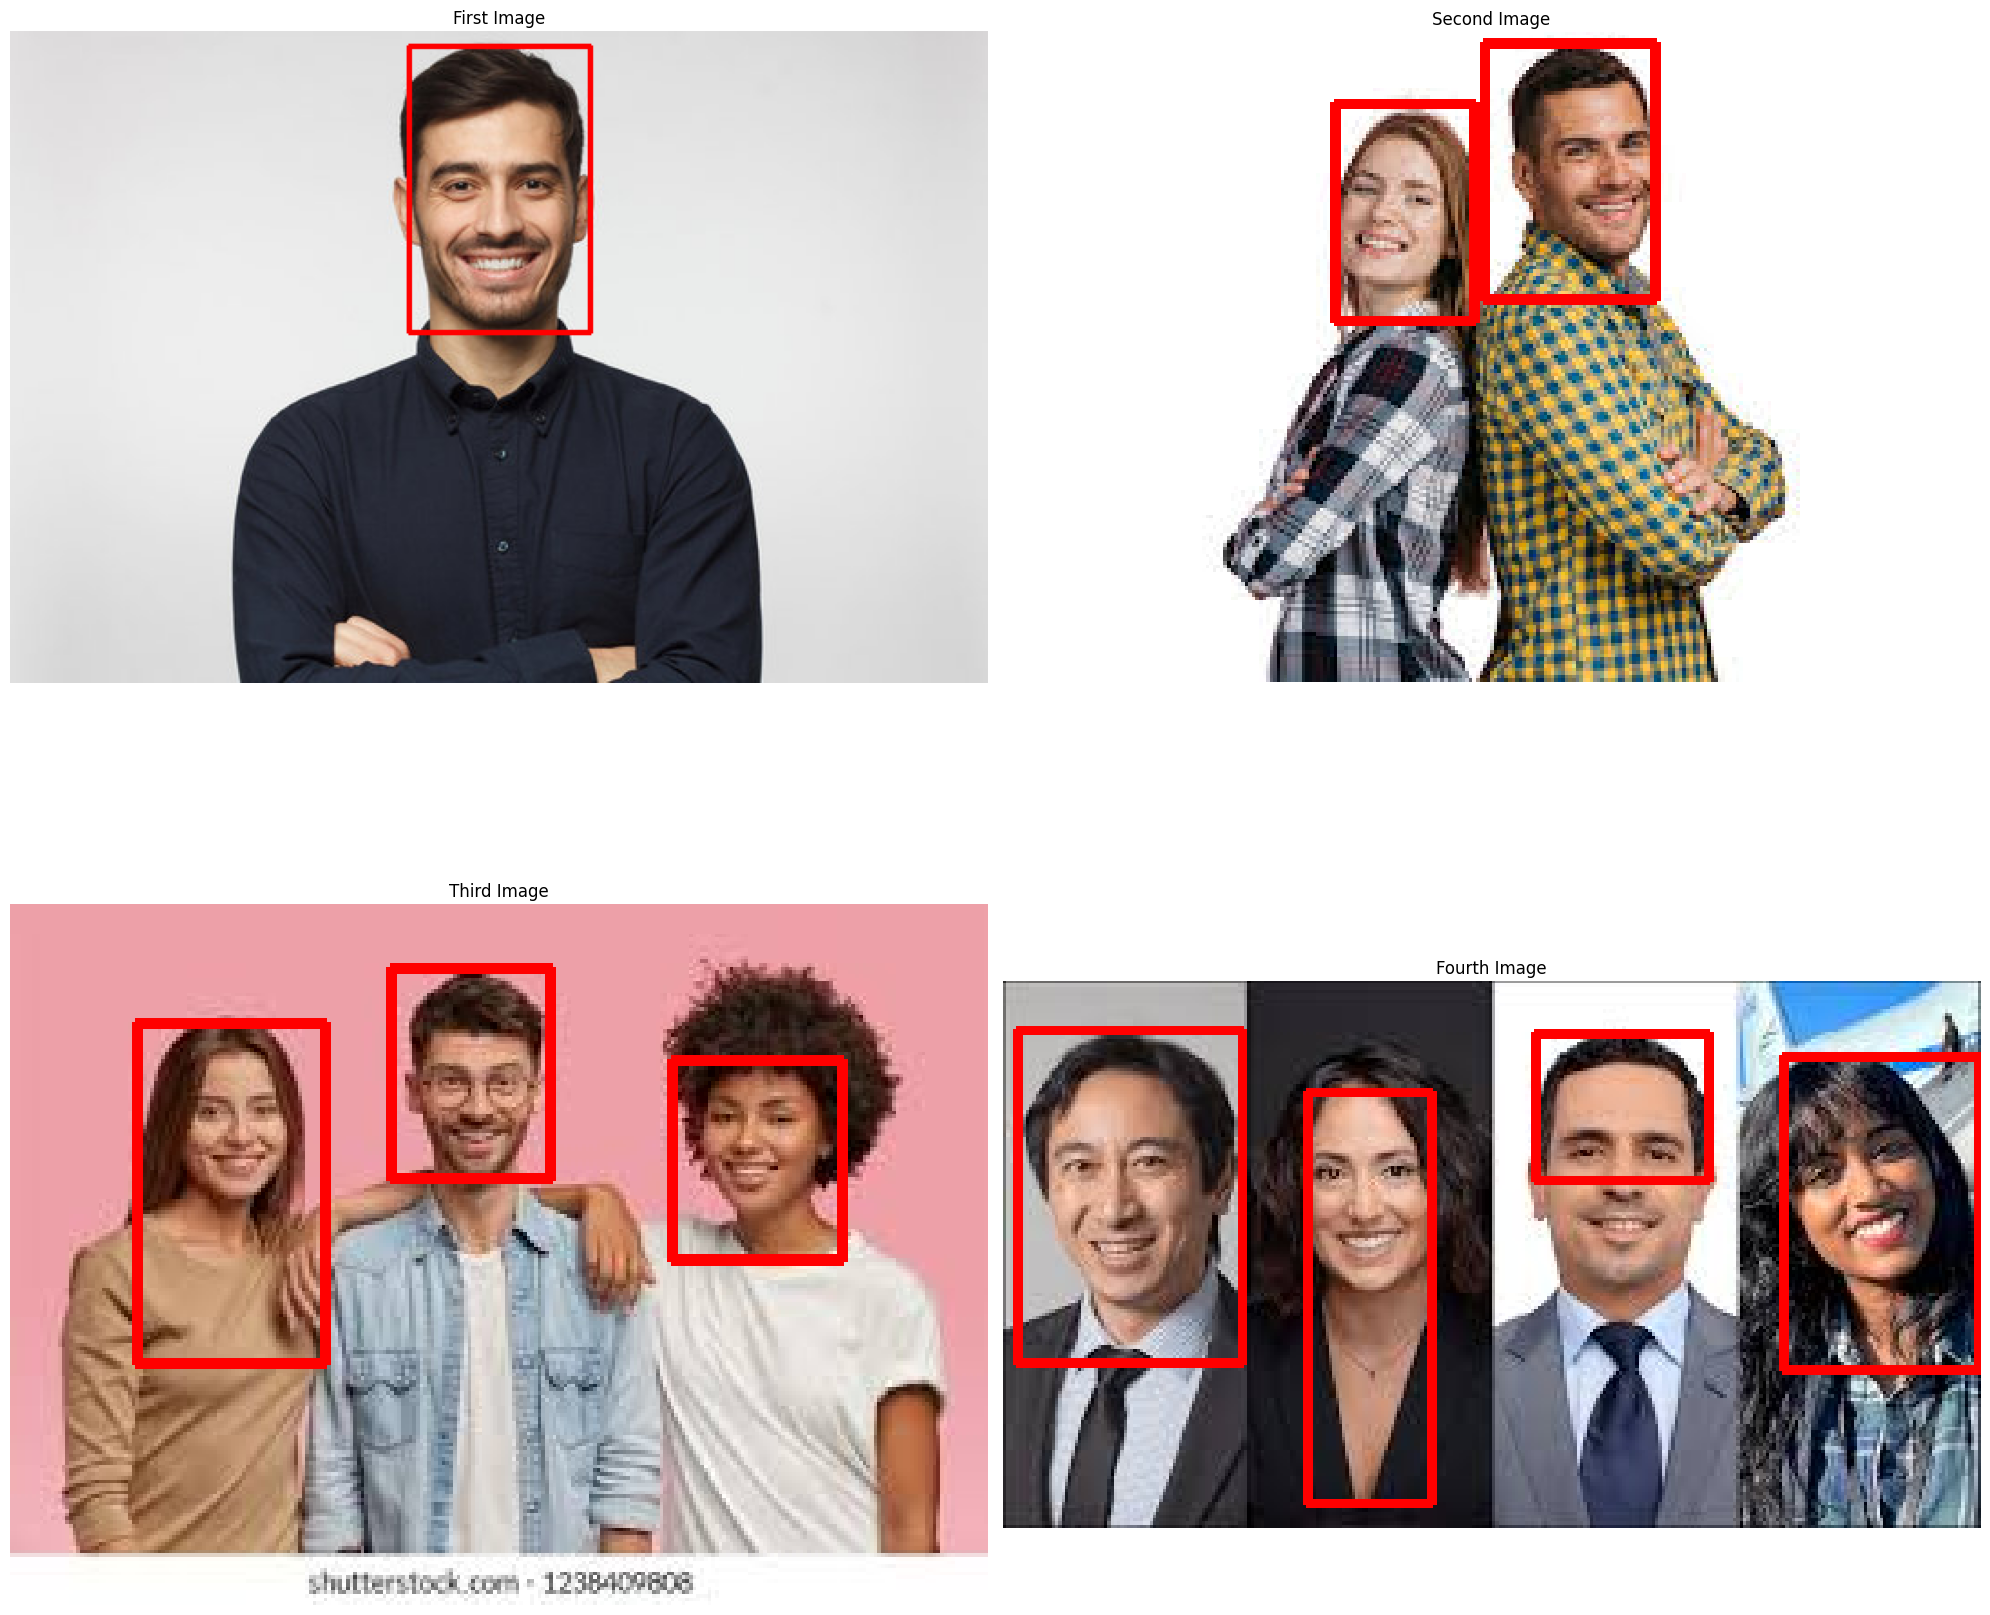

In [10]:
# ---------------------------
# Load Image
# ---------------------------

# Load the image to analyze
image_path = "photo/prova_easy.jpg"
input_image = cv2.imread(image_path)
input_image_rgb1 = cv2.cvtColor(input_image, cv2.COLOR_BGR2RGB)
# Load the image to analyze
image_path = "photo/prova_easu1.jpg"
input_image = cv2.imread(image_path)
input_image_rgb2 = cv2.cvtColor(input_image, cv2.COLOR_BGR2RGB)
# Load the image to analyze
image_path = "photo/three.jpg"
input_image = cv2.imread(image_path)
input_image_rgb3 = cv2.cvtColor(input_image, cv2.COLOR_BGR2RGB)
# Load the image to analyze
image_path = "photo/four.jpg"
input_image = cv2.imread(image_path)
input_image_rgb4 = cv2.cvtColor(input_image, cv2.COLOR_BGR2RGB)

# Perform face detection
output_image1 = process_image_for_prediction(input_image_rgb1, model, p_hog, p_gabor, p_log)
output_image2 = process_image_for_prediction(input_image_rgb2, model, p_hog, p_gabor, p_log)
output_image3 = process_image_for_prediction(input_image_rgb3, model, p_hog, p_gabor, p_log)
output_image4 = process_image_for_prediction(input_image_rgb4, model, p_hog, p_gabor, p_log)

# Create a subplot (4 row, 2 columns)
fig, axs = plt.subplots(2, 2, figsize=(20, 20))  # Adjust the figure size to fit 3 images

# Image 1
axs[0][0].imshow(output_image1)
axs[0][0].axis("off")
axs[0][0].set_title("First Image")

# Image 2
axs[0][1].imshow(output_image2)
axs[0][1].axis("off")
axs[0][1].set_title("Second Image")

# Image 3
axs[1][0].imshow(output_image3)  # Replace with another image or variant
axs[1][0].axis("off")
axs[1][0].set_title("Third Image")

# Image 4
axs[1][1].imshow(output_image4)
axs[1][1].axis("off")
axs[1][1].set_title("Fourth Image")

# Display the subplot
plt.tight_layout()
plt.show()
